In [ ]:
!pip install pywavelets
!pip install ruptures
import ruptures as rpt
import pywt

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
from scipy import signal
from scipy.signal import savgol_filter, medfilt

from scipy.signal import firwin, lfilter,find_peaks,filtfilt,hilbert,welch
from scipy.fftpack import fft, fftshift

from scipy import integrate

from scipy.integrate import cumtrapz
from scipy.stats import linregress

from tqdm import tqdm
import pywt


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 12.9 MB/s eta 0:00:00


 Fs=1000 hz
 Ts=0.001 s


Text(0.5, 1.0, 'Respuesta en frecuencia señal EMG')

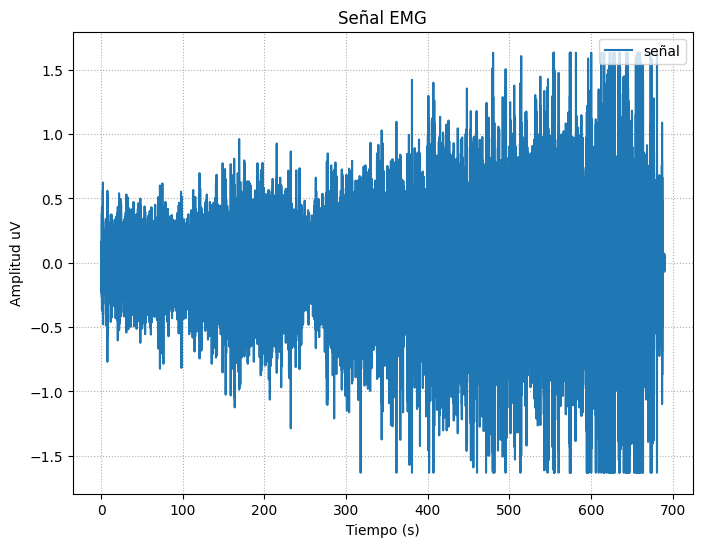

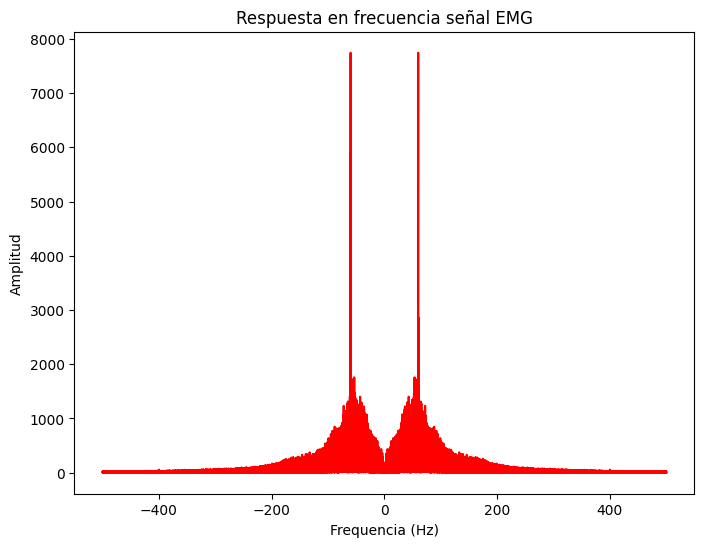

In [ ]:
f = open("gf.txt","r")
raw_data = f.read()  # con f.read() leemos todo el contenido
f.close()

raw_data
Fs = 1000
Ts = 1/Fs
print(f" Fs={Fs} hz\n Ts={Ts} s")

a = np.genfromtxt("./gf.txt", delimiter="\t",skip_header = 3)
eeg = a[:, 5]
N=len(eeg)
bits = 10 # Bits de la salida
volt_range = 3.3
eeg = (eeg/2**bits -1/2) * volt_range/1009
eeg=eeg*1000 # convertir los bits a mV
eeg = eeg - np.mean(eeg)
t = np.arange(1, len(eeg)+1)/Fs
plt.figure(figsize=(8, 6))
plt.plot(t, eeg, label="señal")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud uV")
plt.legend(loc="upper right")
plt.title("Señal EMG")
plt.grid(linestyle=":")


#FFT
def fft_fun(x, fs):
    X = fftshift(fft(x))
    N = len(X)
    w = 2 * np.pi * np.arange(N) / N
    w = np.unwrap(fftshift(w)) - 2 * np.pi
    wHz = w * fs / (2 * np.pi)
    return wHz, X


wHz, Y = fft_fun(eeg, Fs)

#Grafica FFT EEG
plt.figure(figsize=(8, 6))
plt.plot(wHz, np.abs(Y), "r")
plt.xlabel("Frequencia (Hz)")
plt.ylabel("Amplitud")
plt.title("Respuesta en frecuencia señal EMG")

0.113
0.127
1999


Text(0.5, 1.0, 'Respuesta en frecuencia señal EMG filtrada')

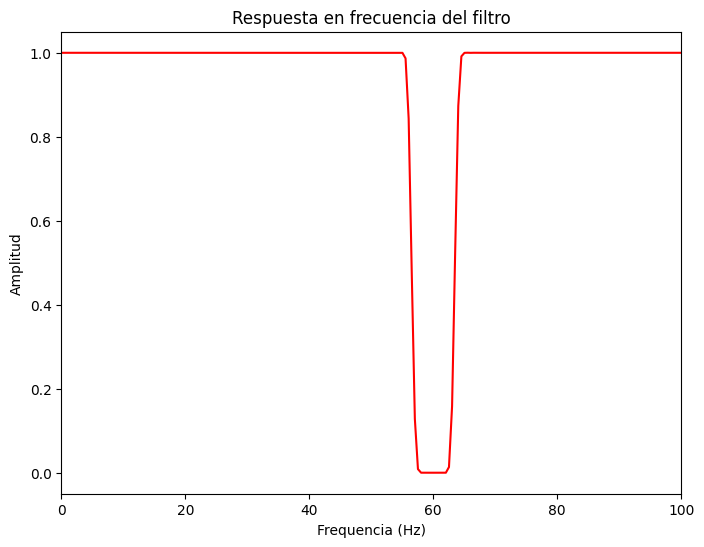

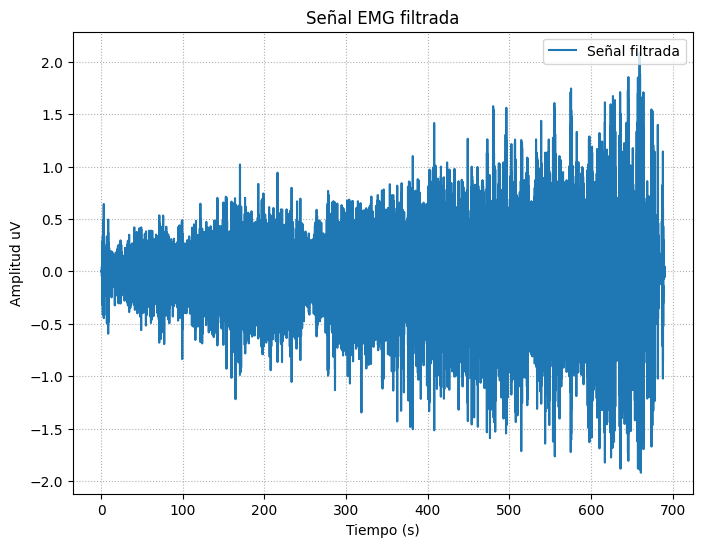

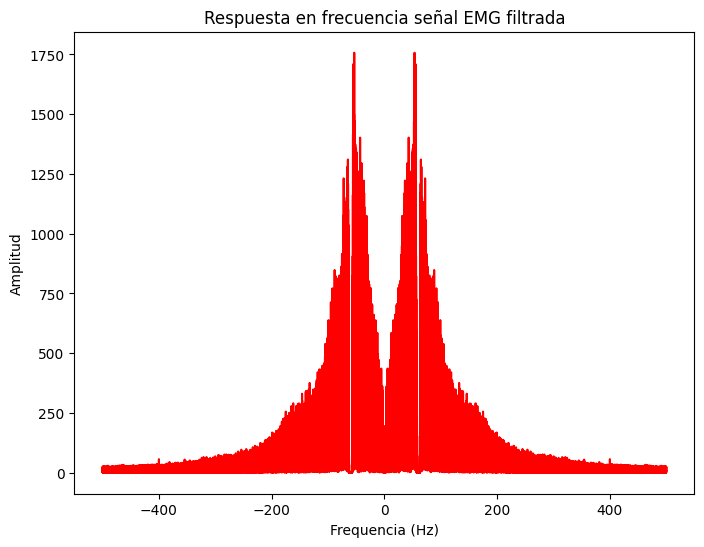

In [ ]:
# Creamos un filtro rechazabanda en 60 Hz
# Definir frecuencias de corte para filtro rechazabanda (RUIDO DE 60 HZ)
wp = 55  / (Fs / 2)
ws = 58  / (Fs / 2)
wc=(wp + ws) / 2
print(wc)
wp1 = 65  / (Fs / 2)
ws1 = 62  / (Fs / 2)
wc1=(wp1 + ws1) / 2

print(wc1)

dw= ws-wp
# Definir el orden del filtro
M =  int(np.floor(12 / dw))
print(M)

stopband_filter= firwin(numtaps=M, cutoff=[wc,wc1],  window='blackman')


wHz, Y = fft_fun(stopband_filter, Fs)

plt.figure(figsize=(8, 6))

plt.plot(wHz, np.abs(Y), "r")
plt.xlabel("Frequencia (Hz)")
plt.ylabel("Amplitud")
plt.title("Respuesta en frecuencia del filtro")
plt.xlim(0,100)



filtered_signal = lfilter(stopband_filter, 1, eeg)

wHz, filtered_signal_fft = fft_fun(filtered_signal, Fs)

t = np.arange(1, len(filtered_signal)+1)/Fs

plt.figure(figsize=(8, 6))
plt.plot(t, filtered_signal, label="Señal filtrada")
plt.title("Señal EMG filtrada")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud uV")
plt.legend(loc="upper right")
plt.grid(linestyle=":")



plt.figure(figsize=(8, 6))
plt.plot(wHz, np.abs(filtered_signal_fft), "r")
plt.xlabel("Frequencia (Hz)")
plt.ylabel("Amplitud")
plt.title("Respuesta en frecuencia señal EMG filtrada")




0.02
0.4


Text(0.5, 1.0, 'Respuesta en frecuencia señal EMG filtrada pasabanda final')

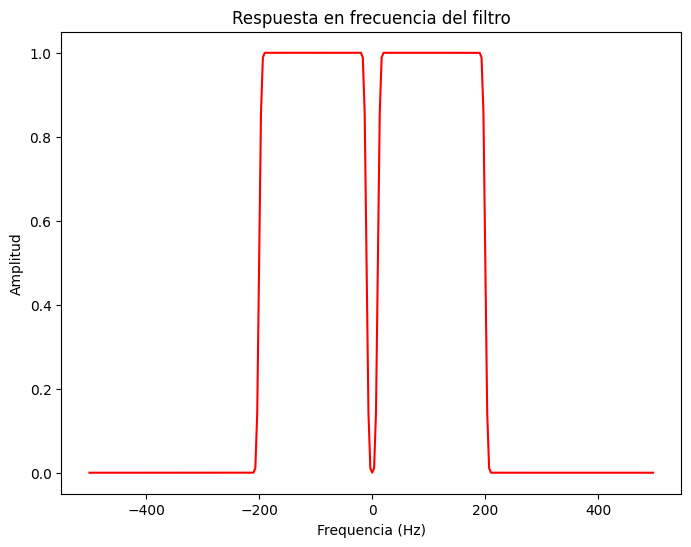

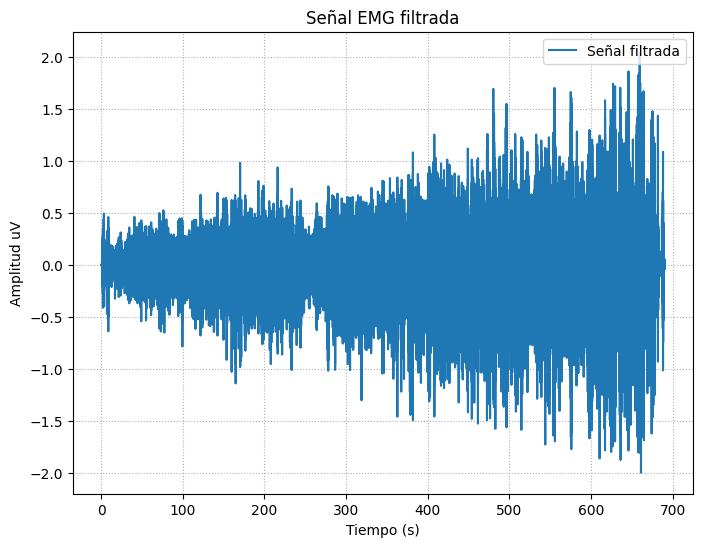

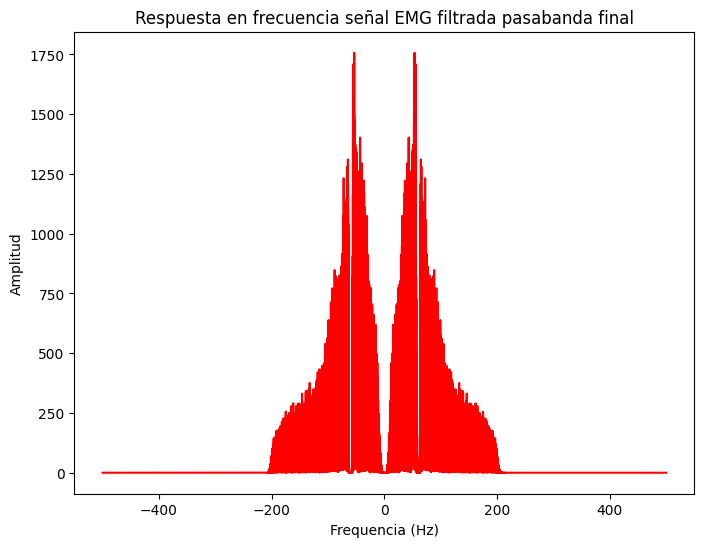

In [ ]:
# Se recomienda un filtro pasabanda con fc de 10 a 200 hz, se la aplicamos a la señal
#filtrada con el rechazabanda


wc_10= 10/ (Fs / 2)
print(wc_10)

wc_200=  200/ (Fs / 2)

print(wc_200)

# Definir el orden del filtro
M = 300

bandpass_filter= firwin(numtaps=M, cutoff=[wc_10,wc_200], pass_zero=False,  window='blackman')


wHz, Y = fft_fun(bandpass_filter, Fs)

plt.figure(figsize=(8, 6))

plt.plot(wHz, np.abs(Y), "r")
plt.xlabel("Frequencia (Hz)")
plt.ylabel("Amplitud")
plt.title("Respuesta en frecuencia del filtro")




filtered_signal2 = lfilter(bandpass_filter, 1, filtered_signal)

wHz, filtered_signal_fft2 = fft_fun(filtered_signal2, Fs)

t = np.arange(1, len(filtered_signal2)+1)/Fs

plt.figure(figsize=(8, 6))
plt.plot(t, filtered_signal2, label="Señal filtrada")
plt.title("Señal EMG filtrada")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud uV")
plt.legend(loc="upper right")
plt.grid(linestyle=":")



plt.figure(figsize=(8, 6))
plt.plot(wHz, np.abs(filtered_signal_fft2), "r")
plt.xlabel("Frequencia (Hz)")
plt.ylabel("Amplitud")
plt.title("Respuesta en frecuencia señal EMG filtrada pasabanda final")



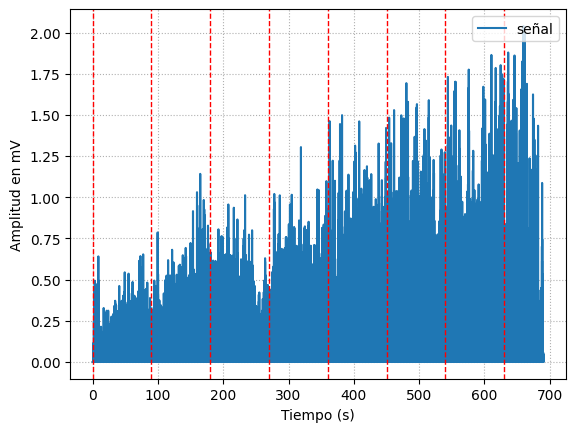

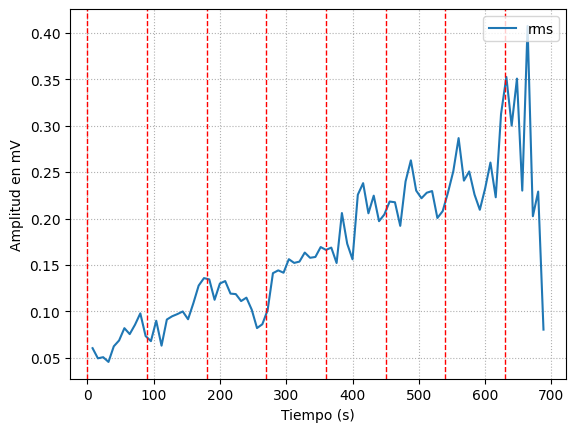

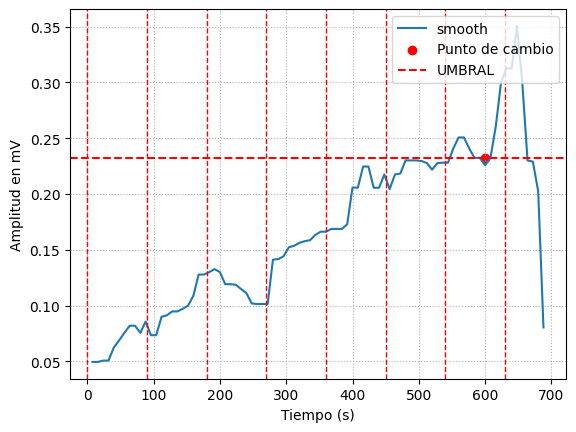

[35, 86]


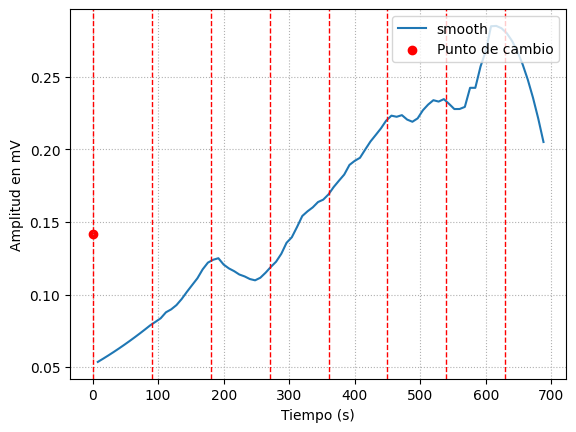

In [ ]:
# EXTRACIÓN DE CARACTERÍSTICAS
xarray=t

muestras_por_grupo = 600
num_grupos = len(filtered_signal2) // muestras_por_grupo

emg = []


rectified_signal = np.abs(filtered_signal2)


plt.plot(t, rectified_signal, label="señal")
plt.grid(linestyle=":")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud en mV")
for i in range(8):
  plt.axvline(x=90*i, color='red', linestyle='--', linewidth=1)
plt.legend(loc="upper right")
plt.show()
###
muestras = 600
num_grupos = len(rectified_signal) // muestras
emg = []
##
for i in range(num_grupos):
    inicio = i * muestras_por_grupo
    fin = (i + 1) * muestras_por_grupo
    promedio_grupo = np.max(rectified_signal[inicio:fin])
    emg.append(promedio_grupo)

xarray = np.arange(1, (len(rectified_signal)+1)/muestras)/(Fs/muestras)
plt.figure()
##

window_size = int(8 * Fs)  #
step_size = window_size

rms_values = []
for i in range(0, len(rectified_signal) - window_size + 1, step_size):
    window = rectified_signal[i:i + window_size]
    rms = np.sqrt(np.mean(window ** 2))
    rms_values.append(rms)
xarray = np.arange(1, (len(rectified_signal)/step_size))/(Fs/step_size)


plt.plot(xarray, rms_values, label="rms")
plt.grid(linestyle=":")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud en mV")
plt.legend(loc="upper right")
for i in range(8):
  plt.axvline(x=90*i, color='red', linestyle='--', linewidth=1)
plt.show()




window_size_median = 5
smoothed_emg_median = medfilt(rms_values, window_size_median)

###################
model = "l1" #"l2" o "rbf"
algo = rpt.Window(width=15, model=model).fit(smoothed_emg_median)
result = algo.predict(n_bkps=1)

# Obtiene el punto de cambio brusco
change_point = result[0]

##############################


plt.figure()
plt.plot(xarray, smoothed_emg_median, label="smooth")
plt.scatter(t[change_point*8000], smoothed_emg_median[change_point], color='red', label='Punto de cambio')
plt.axhline(y=smoothed_emg_median[change_point], color='red', linestyle='--', label='UMBRAL')

plt.grid(linestyle=":")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud en mV")
plt.legend(loc="upper right")
for i in range(8):
  plt.axvline(x=90*i, color='red', linestyle='--', linewidth=1)
plt.show()

window_size = 21
poly_order = 2
smoothed_emg_sg = savgol_filter(rms_values, window_size, poly_order)

###################
model = "l1" #"l2" o "rbf"
algo2 = rpt.Window(width=15, model=model).fit(smoothed_emg_sg)
result = algo2.predict(n_bkps=1)
print(result)
# Obtiene el punto de cambio brusco
change_point2 = result[0]

##############################
plt.figure()
plt.plot(xarray, smoothed_emg_sg, label="smooth")
plt.scatter(t[change_point2], smoothed_emg_median[change_point2], color='red', label='Punto de cambio')

plt.grid(linestyle=":")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud en mV")
plt.legend(loc="upper right")
for i in range(8):
  plt.axvline(x=90*i, color='red', linestyle='--', linewidth=1)
plt.show()



600.0


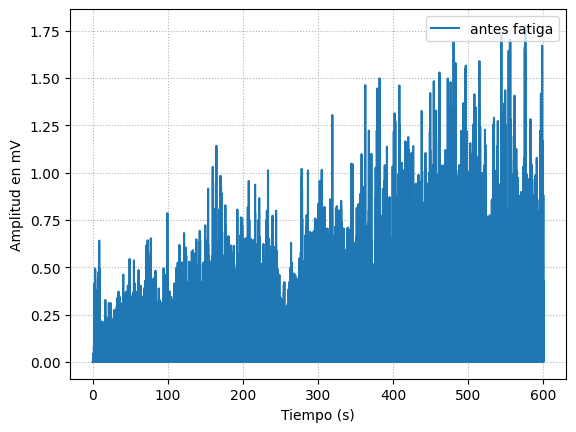

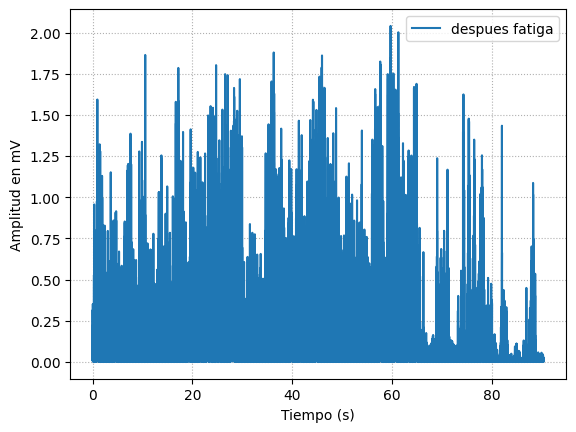

In [ ]:

# Separación de arrays
corte2=change_point*8000
print(corte2/1000)

antes_fatiga= rectified_signal[:corte2]
despues_fatiga = rectified_signal[corte2:]
t1 = np.arange(1, len(antes_fatiga)+1)/Fs
t2 = np.arange(1, len(despues_fatiga)+1)/Fs

plt.figure()
plt.plot(t1,antes_fatiga, label="antes fatiga")
plt.grid(linestyle=":")
plt.legend(loc="upper right")

plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud en mV")

plt.show()

plt.figure()
plt.plot(t2,despues_fatiga, label="despues fatiga")
plt.legend(loc="upper right")

plt.grid(linestyle=":")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud en mV")
plt.show()


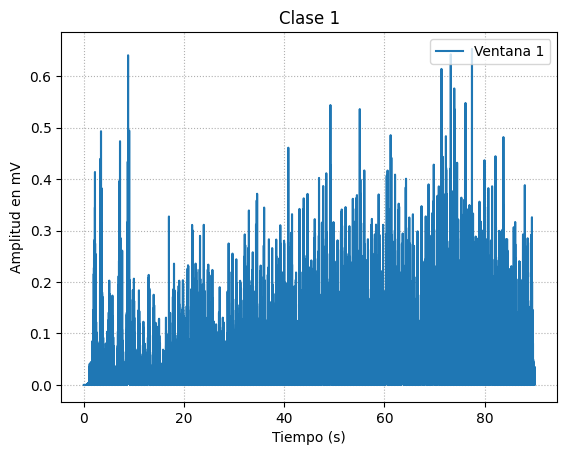

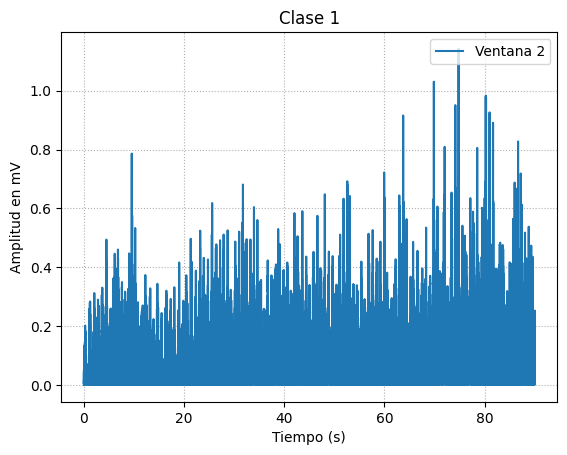

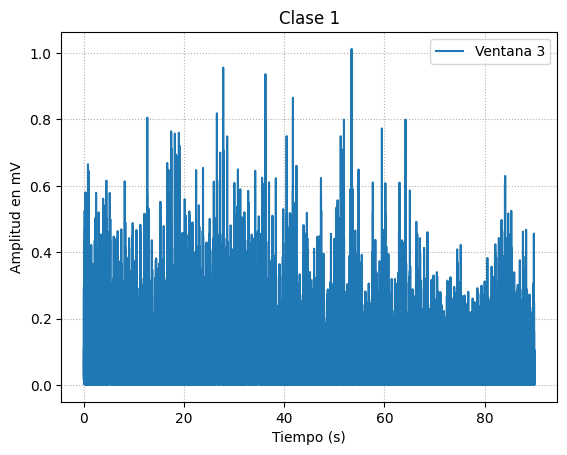

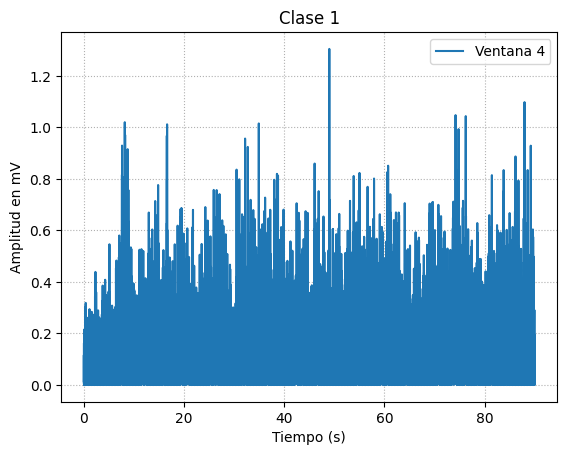

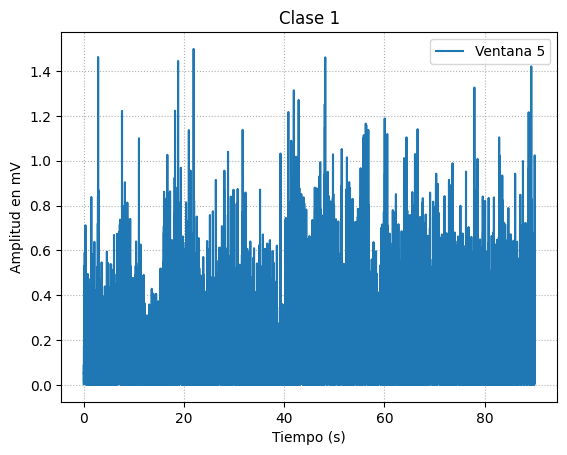

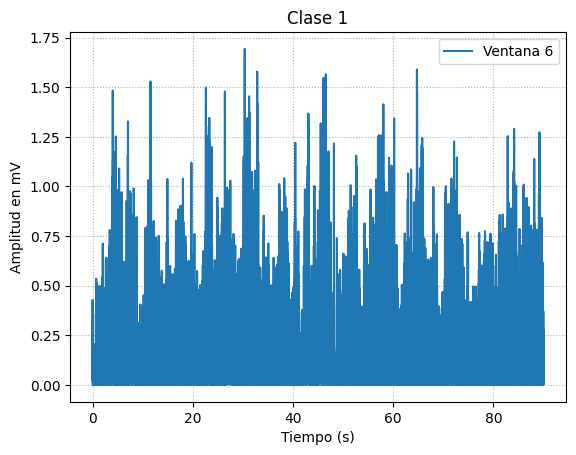

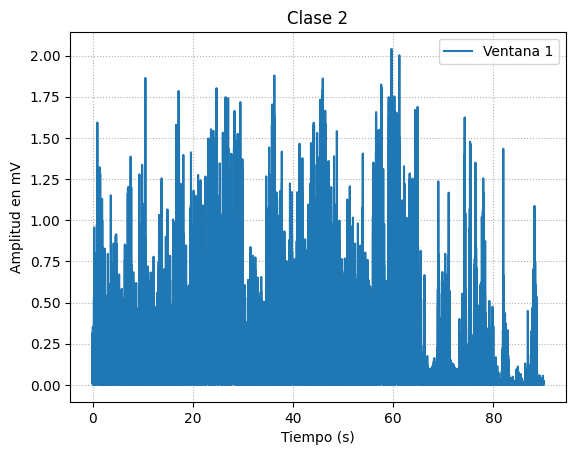

In [56]:
import numpy as np
import matplotlib.pyplot as plt

def divide_en_ventanas(signal, ventana_size, step_size, Fs):
    ventanas = []
    for i in range(0, len(signal) - ventana_size + 1, step_size):
        ventana = signal[i:i + ventana_size]
        ventanas.append(ventana)
    return ventanas

def graficar_ventanas(arrays, Fs, clase):
    for i, ventana in enumerate(arrays):
        tiempo = np.arange(1, len(ventana) + 1) / Fs
        plt.figure()
        plt.plot(tiempo, ventana, label=f'Ventana {i + 1}')
        plt.xlabel('Tiempo (s)')
        plt.ylabel('Amplitud en mV')
        plt.title(f'Clase {clase}')
        plt.legend(loc='upper right')
        plt.grid(linestyle=':')
        plt.show()

Fs = 1000
ventana_size = int(90 * Fs)
step_size = int(90 * Fs)

ventanas_antes_fatiga = divide_en_ventanas(antes_fatiga, ventana_size, step_size, Fs)
ventanas_despues_fatiga = divide_en_ventanas(despues_fatiga, ventana_size, step_size, Fs)

arrays_antes_fatiga = [np.array(ventana) for ventana in ventanas_antes_fatiga]
arrays_despues_fatiga = [np.array(ventana) for ventana in ventanas_despues_fatiga]

# Graficas Antes de la fatiga Ventanas 1 -6
graficar_ventanas(arrays_antes_fatiga, Fs, clase='1')

# Graficar Después de la fatiga Ventana 1
graficar_ventanas(arrays_despues_fatiga, Fs, clase='2')



In [50]:
import numpy as np

# Función para calcular los valores de características para cada ventana
def calcular_caracteristicas(arrays):
    for i, ventana in enumerate(arrays):
        rms = np.sqrt(np.mean(ventana ** 2))
        mean = np.mean(ventana)
        std = np.std(ventana)
        amplitude = np.max(ventana) - np.min(ventana)
        max_sample_value = np.max(ventana)
        min_sample_value = np.min(ventana)

        print(f"\nCaracterísticas de la Ventana {i + 1}:")
        print(f"Root Mean Square (rms): {rms}")
        print(f"Mean EMG (media): {mean}")
        print(f"Standard Deviation  EMG (desviacion_estándar): {std}")
        print(f"Amplitude (amplitud): {amplitude}")
        print(f"Maximo valor EMG: {max_sample_value}")
        print(f"Minimo valor EMG: {min_sample_value}")

# Calcular características para ventanas antes de la fatiga
calcular_caracteristicas(arrays_antes_fatiga)

# Calcular características para ventanas después de la fatiga
calcular_caracteristicas(arrays_despues_fatiga)



Características de la Ventana 1:
Root Mean Square (rms): 0.06998848887181375
Mean EMG (media): 0.043447051956658524
Standard Deviation  EMG (desviacion_estándar): 0.05487023100767312
Amplitude (amplitud): 0.6531574224048674
Maximo valor EMG: 0.6531574224048674
Minimo valor EMG: 1.9856660094999573e-43

Características de la Ventana 2:
Root Mean Square (rms): 0.10142212505088521
Mean EMG (media): 0.06247041319701605
Standard Deviation  EMG (desviacion_estándar): 0.07989927987680162
Amplitude (amplitud): 1.141973780141383
Maximo valor EMG: 1.1419758900712107
Minimo valor EMG: 2.1099298277043365e-06

Características de la Ventana 3:
Root Mean Square (rms): 0.11280468385094279
Mean EMG (media): 0.07292215177516372
Standard Deviation  EMG (desviacion_estándar): 0.08606541976421854
Amplitude (amplitud): 1.0124321603875046
Maximo valor EMG: 1.0124328457480363
Minimo valor EMG: 6.853605316402939e-07

Características de la Ventana 4:
Root Mean Square (rms): 0.1541300164319725
Mean EMG (media): 

In [ ]:

rms = np.sqrt(np.sum(filtered_signal2*filtered_signal2)/len(filtered_signal2))
mean=np.mean(filtered_signal2)
std=np.std(filtered_signal2)
amplitude=np.max(filtered_signal2)-np.min(filtered_signal2)



print(f"Root Mean Square (rms): {rms}")
print(f"Mean EMG (media): {mean}")
print(f"Standard Deviation  EMG(desviacion_estándar): {std}")
print(f"Amplitude (amplitud): {amplitude}")

max_sample_value = max(filtered_signal2)
print(f"Maximo valor EMG: {max_sample_value}")


min_sample_value = min(filtered_signal2)
print(f"Minimo valor EMG: {min_sample_value}")

area=cumtrapz(filtered_signal2)
f,P=welch(filtered_signal2,fs=1000,window='hann',noverlap=0,nfft=int(256.))
area_freq=cumtrapz(P,f,initial=0)
total_power=area_freq[-1]
median_freq=f[np.where(area_freq>total_power/2)[0][0]]
f_max=f[np.argmax(P)]
print("Área bajo la curva:", area[-1])
print("Potencia Total:", total_power)
print("Frecuencia Mediana:",median_freq)
print("Frecuencia con Máxima Potencia:", f_max)


Root Mean Square (rms): 0.18343201512678653
Mean EMG (media): 2.7589607499766414e-08
Standard Deviation  EMG(desviacion_estándar): 0.18343201512678442
Amplitude (amplitud): 4.042014555186006
Maximo valor EMG: 2.0403139615214627
Minimo valor EMG: -2.0017005936645433
Área bajo la curva: 0.01457119037943719
Potencia Total: 0.033680870299625666
Frecuencia Mediana: 58.59375
Frecuencia con Máxima Potencia: 50.78125


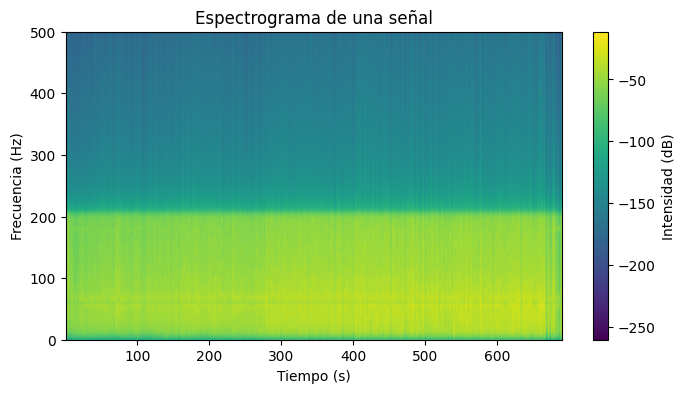

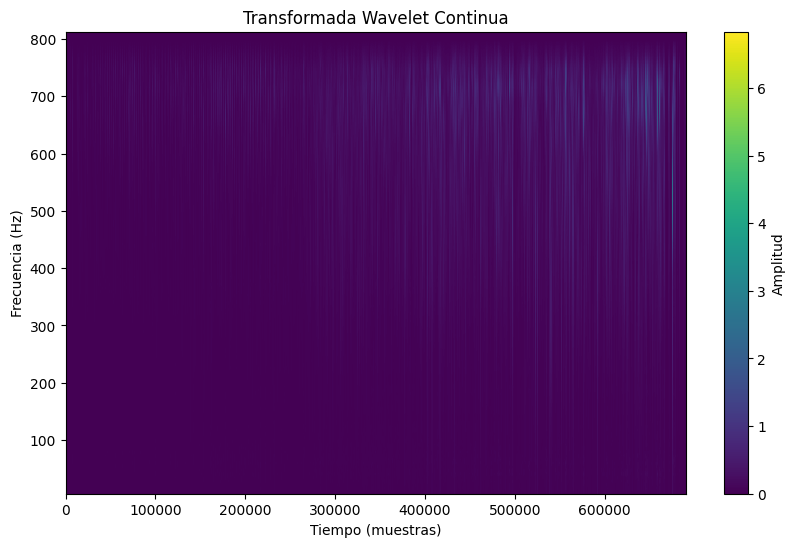

In [ ]:
plt.figure(figsize=(8, 4))
plt.specgram(filtered_signal2, Fs=1000, cmap='viridis')

plt.title('Espectrograma de una señal')
plt.xlabel('Tiempo (s)')
plt.ylabel('Frecuencia (Hz)')

plt.colorbar(label='Intensidad (dB)')
plt.show()


wavelet = 'morl'  # Tipo de wavelet (en este caso, Morlet)
scales = np.arange(1, 128)  # Escalas de análisis
sampling_period = 1 / 1000  # Período de muestreo de la señal

# Realizar la Transformada Wavelet Continua
coeffs, freqs = pywt.cwt(filtered_signal2, scales, wavelet, sampling_period)

# Graficar la CWT
plt.figure(figsize=(10, 6))
plt.imshow(np.abs(coeffs), extent=[0, len(filtered_signal2), freqs.min(), freqs.max()], aspect='auto', cmap='viridis')
plt.colorbar(label='Amplitud')
plt.title('Transformada Wavelet Continua')
plt.xlabel('Tiempo (muestras)')
plt.ylabel('Frecuencia (Hz)')
plt.show()


In [ ]:
import csv

def convert_txt_to_csv(input_file, output_file, delimiter='\t'):
    with open(input_file, 'r') as txt_file, open(output_file, 'w', newline='') as csv_file:
        reader = csv.reader(txt_file, delimiter=delimiter)
        writer = csv.writer(csv_file)

        for row in reader:
            if len(row) >= 6:
                writer.writerow([row[5]])

input_txt_file = 'gf.txt'
output_csv_file = 'gf.csv'

convert_txt_to_csv(input_txt_file, output_csv_file)


In [44]:

# Importamos librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
# Extraemos datos
data="gf.csv"
#visualizamos el dataset
df= pd.read_csv(data)
df.head()

import csv

def classify_and_save_to_csv(input_file, output_file, corte):
    with open(input_file, 'r') as infile:
        reader = csv.reader(infile)
        header = next(reader)
        data = [(float(row[0]),) for row in reader]

    class_1 = [(value, 'Class 1', '') for value, in data[:corte]]
    class_2 = [(value, '', 'Class 2') for value, in data[corte:]]

    with open(output_file, 'w', newline='') as outfile:
        writer = csv.writer(outfile)
        writer.writerow(['Value', 'Class 1', 'Class 2'])
        for value, class1, class2 in class_1:
            writer.writerow([value, class1, class2])
        for value, class1, class2 in class_2:
            writer.writerow([value, class1, class2])

# Example usage
input_csv_file = 'gf.csv'
output_csv_file = 'classified_data.csv'

classify_and_save_to_csv(input_csv_file, output_csv_file, corte2)



In [53]:
import csv
import numpy as np

def calcular_caracteristicas(arrays, clase):
    caracteristicas = []
    for i, ventana in enumerate(arrays):
        rms = np.sqrt(np.mean(ventana ** 2))
        mean = np.mean(ventana)
        std = np.std(ventana)
        amplitude = np.max(ventana) - np.min(ventana)
        max_sample_value = np.max(ventana)
        min_sample_value = np.min(ventana)

        caracteristicas.append([clase, i + 1, rms, mean, std, amplitude, max_sample_value, min_sample_value])

    return caracteristicas

caracteristicas_antes_fatiga = calcular_caracteristicas(arrays_antes_fatiga, clase='Clase 1')
caracteristicas_despues_fatiga = calcular_caracteristicas(arrays_despues_fatiga, clase='Clase 2')
todas_caracteristicas = caracteristicas_antes_fatiga + caracteristicas_despues_fatiga

archivo_csv = 'caracteristicas_ventanas.csv'
with open(archivo_csv, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Clase', 'Etiqueta', 'RMS', 'Media', 'Desviacion_Estandar', 'Amplitud', 'Maximo', 'Minimo'])
    writer.writerows(todas_caracteristicas)

